In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt5
%matplotlib inline

nx = 9 #number of inside corners in x
ny = 6 #umber of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    




In [164]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #plt.imshow(sxbinary, cmap='gray')
    # 6) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx * sobelx + sobely * sobely) 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
   
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#combining the three methods: 
def combine_grad_thresh(img):
    # Apply each of the thresholding functions
    # Choose a Sobel kernel size
    ksize = 9 # Choose a larger odd number to smooth gradient measurements
    # Run the function
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))



    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined


# Color thresholding, taking the saturation channel from the HLS color space
def hls_saturation(img, thresh=(90, 220)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_s = np.zeros_like(s)
    binary_s[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return binary_s

def rgb_channel_r(img, thresh=(150, 255)):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    binary_R = np.zeros_like(R)
    binary_R[(R >= thresh[0]) & (R <= thresh[1])] = 1
    return binary_R

def calc_points(image_size):
   
    top_left = [570,470]
    top_right = [720, 470]
    bottom_right = [1130,720]
    bottom_left = [200,720]
    source = np.float32([bottom_left,bottom_right,top_left,top_right])
    
    top_left_dst = [320,0]
    top_right_dst = [980,0]
    bottom_right_dst = [980,720]
    bottom_left_dst = [320,720]
    dst = np.float32([bottom_left_dst,bottom_right_dst,top_left_dst,top_right_dst])
    
    return dst, source

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids




In [16]:

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [155]:

def finding_lanes(binary_warped):
  
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 18
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Check 1: check if left and right fits exists
    #if len(left_fit) ==0 or len(right_fit) == 0:
    #    return left_fitx, right_fitx, left_fit, right_fit, ploty, result
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.show()
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    #plt.imshow(result)
    #plt.show()
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty, result

def sanity_check(left_lane, right_lane, leftx, rightx):       
    
    #Checking that they have similar curvature
    #Checking that they are separated by approximately the right distance horizontally
    #Checking that they are roughly parallel
    
    #Check 1: check if left and right fits exists
    width = abs(leftx[719] - rightx[719])
            
    if left_lane.detected & right_lane.detected: # If lane is detected
        #Checking that they have similar curvature 700px
        if abs(abs(left_lane.allx[719] - right_lane.allx[719])- width) < 20:        
            left_lane.detected = True
            left_lane.allx = leftx
            left_lane.bestx = np.mean(leftx)   
            
            right_lane.detected = True
            right_lane.allx = rightx
            right_lane.bestx = np.mean(rightx)   
        # If sanity check fails use the previous values
        else:
            left_lane.detected = False
            right_lane.detected = False
            return left_lane.allx, right_lane.allx
    else:
        if (left_lane.allx is not None) & (right_lane.allx is not None):
            if abs(abs(left_lane.allx[719] - right_lane.allx[719])- width) < 30:        
                left_lane.detected = True
                left_lane.allx = leftx
                left_lane.bestx = np.mean(leftx)   

                right_lane.detected = True
                right_lane.allx = rightx
                right_lane.bestx = np.mean(rightx)   
            # If sanity check fails use the previous values
            else:
                left_lane.detected = False
                right_lane.detected = False
                return left_lane.allx, right_lane.allx
        # If curvature was defined
        else:
            left_lane.detected = True
            left_lane.allx = leftx
            left_lane.bestx = np.mean(leftx)   

            right_lane.detected = True
            right_lane.allx = rightx
            right_lane.bestx = np.mean(rightx) 
            
    return leftx, rightx
    

In [156]:
def measure_curve(leftx, rightx, ploty):
    
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    #Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

def measure_center(leftx, rightx, imgshape):
    #You can assume the camera is mounted at the center of the car, 
    #such that the lane center is the midpoint at the bottom of the 
    #image between the two lines you've detected. 
    #The offset of the lane center from the center 
    #of the image (converted from pixels to meters) 
    #is your distance from the center of the lane.
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
 
    camera_position = imgshape[0]/2
    lane_center = (leftx[719] - rightx[719]) /2
    center_offset_pixels = abs(camera_position - lane_center)
    return center_offset_pixels * xm_per_pix



In [188]:
def pipeline(img):
    image = cal_undistort(img, objpoints, imgpoints)
  
    combined = combine_grad_thresh(image)
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=9, thresh=(20, 100))
    s_binary = hls_saturation(image, thresh=(170,255))
    r_binary = rgb_channel_r(image, thresh=(220,255))
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > 180) & (gray <= 255)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradx)
    combined_binary[(s_binary == 1) | (r_binary == 1) | (combined == 1)] = 1
    
    #buoni
    #combined_binary[(s_binary == 1) | (gradx == 1) | (r_binary == 1)] = 1
    
    #combined_binary[(s_binary == 1) & (binary == 1) | (combined == 1)] = 1
    #combined_binary[(gradx == 1)  | (hls == 1) | (r == 1) ] = 1

    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),
                          (520, 440), 
                          (imshape[1]-510, 440), 
                          (imshape[1]-90,imshape[0])]], dtype=np.int32)
    combined_binary = region_of_interest(combined_binary, vertices)
    
    dst, source = calc_points(image.shape)

    M = cv2.getPerspectiveTransform(source, dst)
    Minv = cv2.getPerspectiveTransform(dst, source)

    img_size = (combined_binary.shape[0], combined_binary.shape[1])
    warped = cv2.warpPerspective(combined_binary, M, gray.shape[::-1] , flags=cv2.INTER_LINEAR)

    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    leftx, rightx, left_fit, right_fit, ploty, result = finding_lanes(warped)
    
    left_curverad, right_curverad = measure_curve(leftx,rightx,ploty)
    position = measure_center(leftx,rightx, gray.shape[::-1])
    
     # Sanity check for the lanes
    leftx, rightx  = sanity_check(left_lane, right_lane, leftx, rightx)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(result,"Left (m): "+ str(round(left_curverad,2)) + " Right (m): "+ str(round(right_curverad,2)), (20,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    resutl = cv2.putText(result,"Position (m): "+ str(round(position,2)), (20,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return result, warped
   

  
    

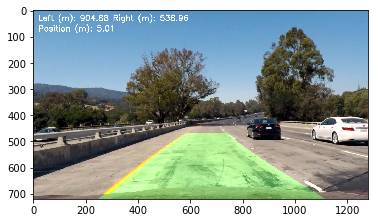

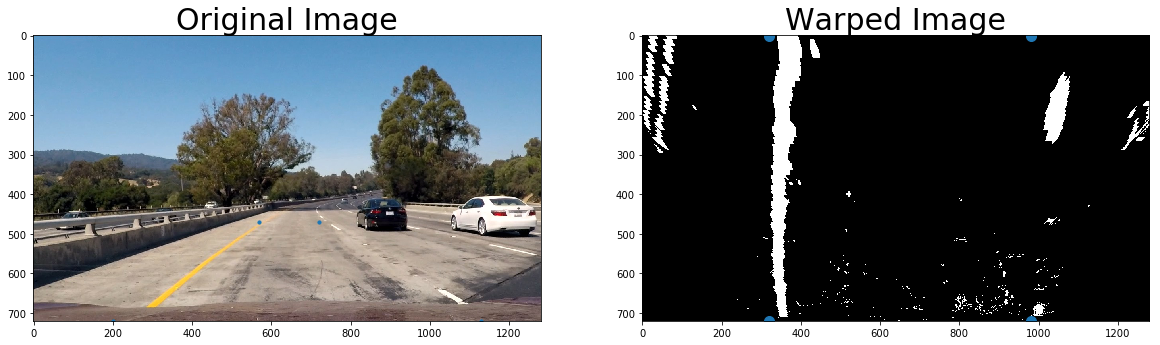

In [195]:

img = mpimg.imread('test_images/test1.jpg')

# Set up lines for left and right
left_lane = Line()
right_lane = Line()    

result, warped = pipeline(img)

plt.imshow(result, cmap='gray')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.scatter([570,720,200,1130],[470,470,720,720],s =10)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.scatter([320,980,320,980],[1,1,720,720],s =100)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)




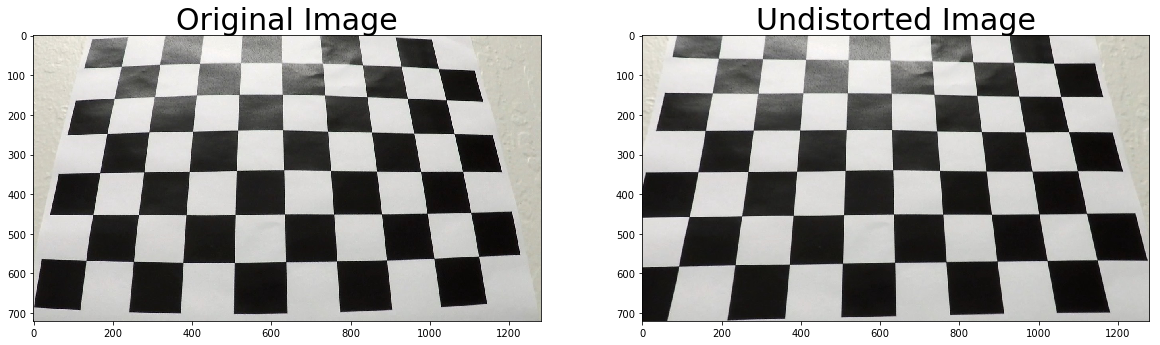

In [12]:

img = mpimg.imread('./camera_cal/calibration3.jpg')
image = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#ax1.scatter([570,720,200,1130],[470,470,720,720],s =10)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

#ax2.scatter([320,980,320,980],[1,1,720,720],s =100)
ax2.imshow(image, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)

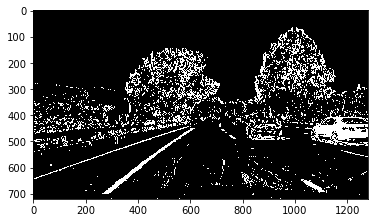

In [67]:
image1 = mpimg.imread('./test_images/test1.jpg')    
image = cal_undistort(image1, objpoints, imgpoints)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


binary = np.zeros_like(gray)
binary[(gray > 180) & (gray <= 255)] = 1



gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=9, thresh=(20, 100))
s_binary = hls_saturation(image, thresh=(170,255))
r_binary = rgb_channel_r(image, thresh=(220,255))

#plt.imshow(r_binary,cmap = 'gray')

# Combine the two binary thresholds
combined_binary = np.zeros_like(gradx)
combined_binary[(s_binary == 1) | (gradx == 1) | (r_binary == 1)] = 1

plt.imshow(combined_binary, cmap='gray')


In [196]:

### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Set up lines for left and right
left_lane = Line()
right_lane = Line()    

def pipeline_video(img):
    result, warped = pipeline(img)
    return result
    
result_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip = clip1.fl_image(pipeline_video) #NOTE: this function expects color images!!
%time result_clip.write_videofile(result_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4



 12%|█▏        | 152/1261 [02:41<19:38,  1.06s/it]


 24%|██▍       | 303/1261 [05:21<16:39,  1.04s/it]


 36%|███▌      | 454/1261 [07:59<13:44,  1.02s/it]


 48%|████▊     | 605/1261 [10:39<11:43,  1.07s/it]


 60%|█████▉    | 756/1261 [13:18<09:45,  1.16s/it]


 72%|███████▏  | 907/1261 [16:00<05:53,  1.00it/s]


 84%|████████▍ | 1057/1261 [18:34<03:40,  1.08s/it]


 96%|█████████▌| 1205/1261 [21:04<00:56,  1.00s/it]


100%|█████████▉| 1260/1261 [21:59<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 21min 23s, sys: 1min 41s, total: 23min 4s
Wall time: 22min 1s
